In [ ]:
# Requisitos previos
! pip install kaggle
! mkdir ~/.kaggle
! cp drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download prasertk/military-power-by-country-2022

  0% 0.00/15.0k [00:00<?, ?B/s]
100% 15.0k/15.0k [00:00<00:00, 11.4MB/s]


In [ ]:
! unzip military-power-by-country-2022.zip

Archive:  military-power-by-country-2022.zip
  inflating: global firepower 2022 wide.csv  


In [ ]:
import pandas as pd
dataframe = pd.read_csv('global firepower 2022 wide.csv')

In [ ]:
dataframe.head()

,country,country_code,Active Personnel,Aircraft Carriers,Armored Vehicles,Attack Helicopters,Available Manpower,Coastline Coverage,Corvettes,Dedicated Attack,Defense Budget,Destroyers,External Debt,Fighters/Interceptors,Fit-for-Service,Foreign Exchange/Gold,Frigates,Helicopter Carriers,Helicopters,Labor Force,Merchant Marine Fleet,Mine Warfare,Navy Ships,Oil Consumption,Oil Production,Oil Proven Reserves,Paramilitary,Patrol Vessels,Ports / Trade Terminals,Purchasing Power Parity,Railway Coverage,Reaching Mil Age Annually,Reserve Personnel,Roadway Coverage,Rocket Projectors,Self-Propelled Artillery,Shared Borders,Special-Mission,Square Land Area,Submarines,Tanker Fleet,Tanks,Total Aircraft Strength,Total Population,Towed Artillery,Trainers,Transports,Waterways (usable)
0,Afghanistan,AFG,0,0,530,0,14611901,0,0,0,99050000,0,284000000,0,8242611,5000000000,0,0,0,8478000,0,0,0,35000,0,0,60000,0,2,36000000000,0,786795,0,34903,13,0,5987,0,652230,0,0,0,0,37466414,60,0,0,1200
1,Albania,ALB,8000,0,76,0,1513309,362,0,0,192400000,0,9311000000,19,1284768,400000000,0,0,19,1104000,70,0,19,29000,14000,168300000,500,19,4,38000000000,677,61768,0,3945,0,0,691,0,28748,0,0,0,19,3088385,0,0,0,41
2,Algeria,ALG,130000,0,6461,45,20916812,998,6,22,9700000000,0,5574000000,552,17779290,100000000000,5,0,268,10859000,114,0,201,405000,1260000,12200000000,200000,25,12,470000000000,3973,697227,135000,104000,334,545,6734,9,2381741,6,5,2196,552,43576691,450,87,58,0
3,Angola,ANG,107000,0,1210,15,6728529,1600,0,18,1059270000,0,42080000000,299,3364265,16995000000,0,0,117,12510000,54,2,40,130000,1600000,9523000000,10000,37,6,205700000000,2852,336426,0,26000,118,28,5369,2,1246700,0,0,320,299,33642646,585,61,30,1300
4,Argentina,ARG,83000,0,800,0,20180574,4989,9,6,3064800000,4,278524000000,218,17153488,45000000000,0,0,85,18000000,202,0,47,806000,490000,2162000000,20000,13,10,900000000000,36917,687974,0,281290,26,75,11968,10,2780400,2,2,349,218,45864941,172,70,22,11000


In [ ]:
labels = dataframe.columns
y_label = 'Reaching Mil Age Annually'
y_index = [i for i,label in enumerate(labels) if y_label==label]
y_index # Variable objetivo

[31]

In [ ]:
import numpy as np
X = dataframe.values[:,2:]
X = np.delete(X,31,axis=1)
Y = dataframe[y_label].values

In [ ]:
print("X:",X.shape)
print("Y:",Y.shape)

X: (140, 45)
Y: (140,)


# A. Normalizacion y escalamiento de datos

Histograma de todo el dataset

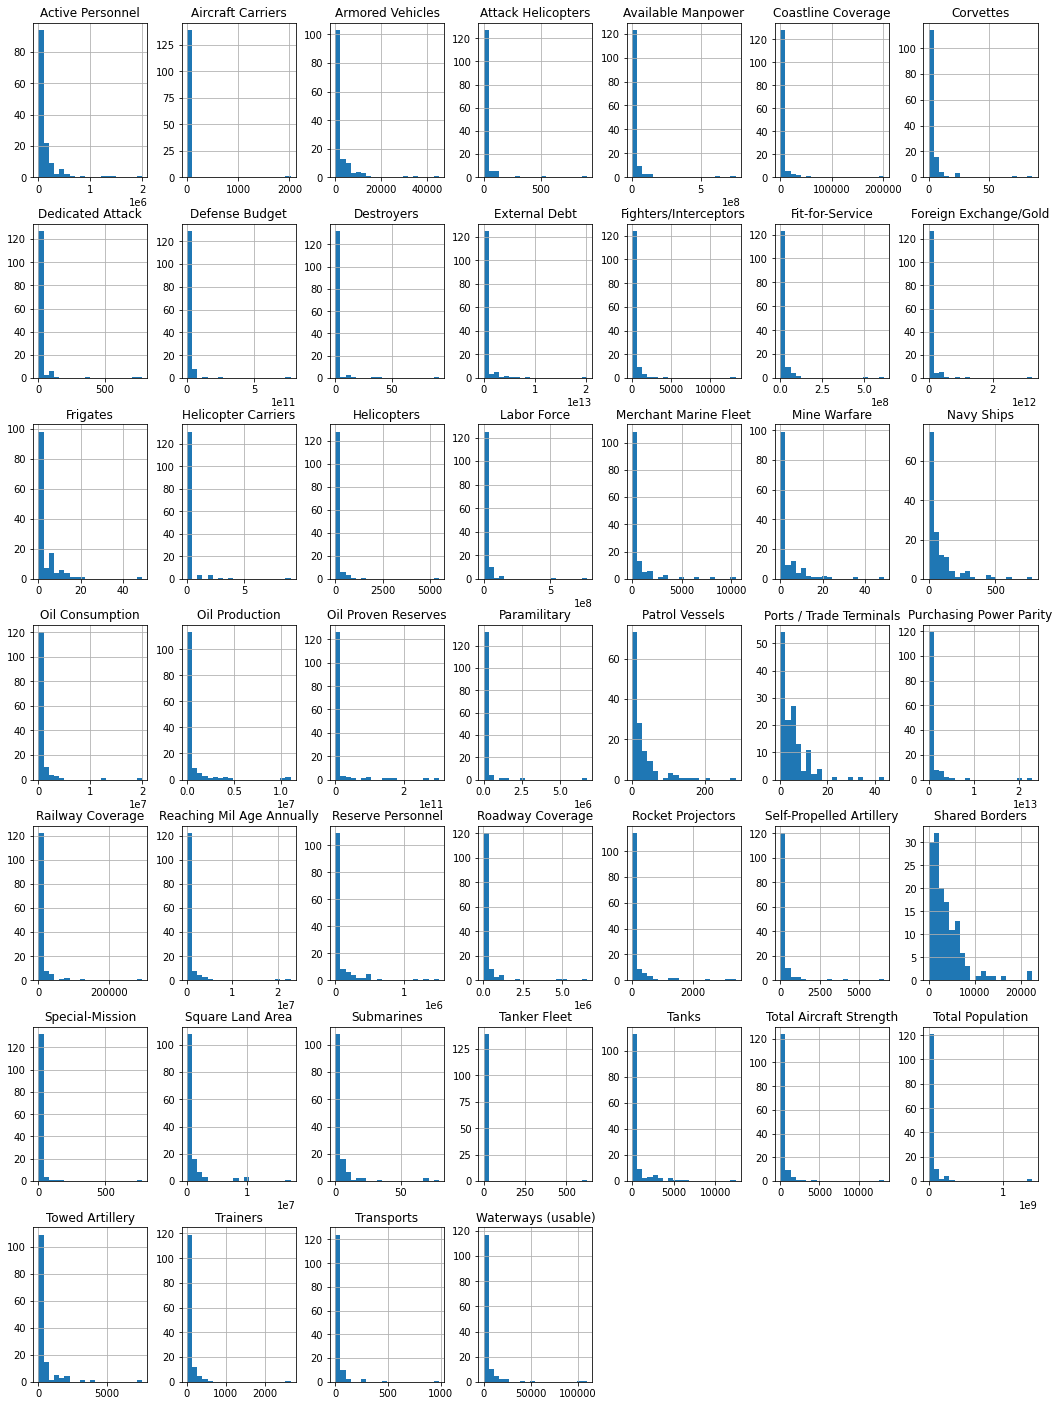

In [ ]:
histograma = dataframe.hist(bins=20 , figsize = (18,25))

In [ ]:
dataframe2 = dataframe.copy()

In [ ]:
dataframe2 = dataframe2[dataframe2['Aircraft Carriers'] < 0.75]

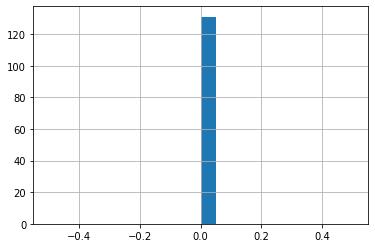

In [ ]:
# Observemos la nueva distribucion
dataframe2['Aircraft Carriers'].hist(bins=20)

Normalizacion manual

In [ ]:
c1= dataframe2['Active Personnel'].values

In [ ]:
c1_log = np.log1p(c1)

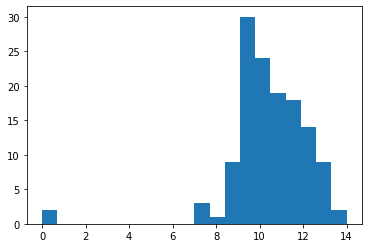

In [ ]:
import matplotlib.pyplot as plt
plt.hist(c1_log, bins = 20)
plt.show()

Normalizacion con scikit

In [ ]:
from sklearn.preprocessing import StandardScaler
sd = StandardScaler()
c1_sd = sd.fit_transform(c1.reshape(-1,1))

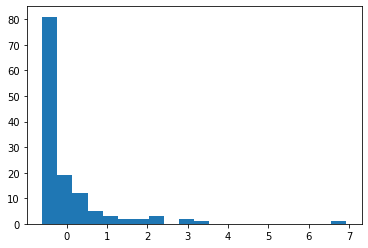

In [ ]:
plt.hist(c1_sd, bins=20)
plt.show()

Grafico de las variables normalizadas

In [ ]:
variables = dataframe.loc[:,['Oil Production', 'Oil Consumption']]
variables = variables.values

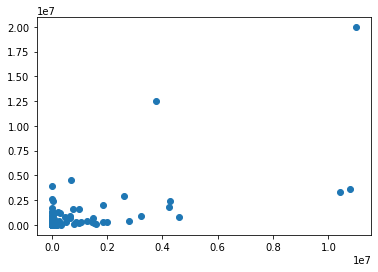

In [ ]:
plt.scatter(variables[:,0],variables[:,1])
plt.show()

In [ ]:
variables_sd = sd.fit_transform(variables)

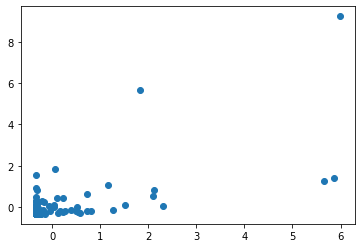

In [ ]:
plt.scatter(variables_sd[:,0],variables_sd[:,1])
plt.show()

# B. Limpieza del dataset

In [ ]:
def whitening(X):
  X = X - np.mean(X, axis=0)
  _, S, V = np.linalg.svd(X)
  A = np.dot(V.T,np.diag(1.0/S))
  X = np.dot(X,A) * np.sqrt(X.shape[0])
  return X, np.cov(X.T)

In [ ]:
X = np.array([[1,2,3],[4,5,6],[1, 2, 1]])

In [ ]:
whitening(X)

(array([[-0.43603315, -1.34531598, -0.71143008],
        [ 1.38309439,  0.2950422 , -4.70086419],
        [-0.94706124,  1.05027378,  5.41229428]]),
 array([[ 1.50000000e+00,  6.68946085e-17, -5.65865296e+00],
        [ 6.68946085e-17,  1.50000000e+00,  2.62726785e+00],
        [-5.65865296e+00,  2.62726785e+00,  2.59485931e+01]]))

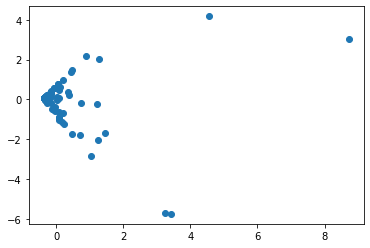

In [ ]:
variables_white, variables_cov = whitening(variables)
plt.scatter(variables_white[:,0],variables_white[:,1])
plt.show()

# C. Seleccion de caracteristicas

In [ ]:
dataframe.describe()

,Active Personnel,Aircraft Carriers,Armored Vehicles,Attack Helicopters,Available Manpower,Coastline Coverage,Corvettes,Dedicated Attack,Defense Budget,Destroyers,External Debt,Fighters/Interceptors,Fit-for-Service,Foreign Exchange/Gold,Frigates,Helicopter Carriers,Helicopters,Labor Force,Merchant Marine Fleet,Mine Warfare,Navy Ships,Oil Consumption,Oil Production,Oil Proven Reserves,Paramilitary,Patrol Vessels,Ports / Trade Terminals,Purchasing Power Parity,Railway Coverage,Reaching Mil Age Annually,Reserve Personnel,Roadway Coverage,Rocket Projectors,Self-Propelled Artillery,Shared Borders,Special-Mission,Square Land Area,Submarines,Tanker Fleet,Tanks,Total Aircraft Strength,Total Population,Towed Artillery,Trainers,Transports,Waterways (usable)
count,1.400000e+02,140.000000,140.000000,140.000000,1.400000e+02,140.000000,140.000000,140.000000,1.400000e+02,140.000000,1.400000e+02,140.000000,1.400000e+02,1.400000e+02,140.000000,140.000000,140.000000,1.400000e+02,140.000000,140.000000,140.000000,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02,140.000000,140.000000,1.400000e+02,140.000000,1.400000e+02,1.400000e+02,1.400000e+02,140.000000,140.000000,140.000000,140.000000,1.400000e+02,140.000000,140.000000,140.000000,140.000000,1.400000e+02,140.000000,140.000000,140.000000,140.000000
mean,1.378579e+05,14.592857,2770.428571,25.178571,2.578443e+07,4820.778571,2.985714,25.950000,1.447492e+10,1.707143,5.917690e+11,378.757143,2.021003e+07,8.718911e+10,2.914286,0.178571,141.442857,2.285256e+07,572.371429,3.164286,75.278571,6.825144e+05,5.901486e+05,1.180398e+10,1.299511e+05,26.885714,5.471429,8.860872e+11,9308.242857,8.485504e+05,9.192143e+04,2.694895e+05,180.607143,221.885714,3670.992857,14.235714,9.419542e+05,3.657143,5.785714,663.264286,378.757143,5.435363e+07,381.692857,81.807143,30.492857,4641.071429
std,2.790035e+05,170.880239,5907.143029,93.304658,8.478686e+07,18474.920517,10.005024,97.011408,6.968119e+10,9.174171,2.075549e+12,1222.932158,6.848590e+07,3.086513e+11,5.872121,0.915634,491.539137,8.018446e+07,1417.383151,6.786159,119.580746,2.094888e+06,1.743666e+06,4.265405e+10,6.327321e+05,43.445838,6.290844,2.725642e+12,29406.899164,2.616430e+06,2.244822e+05,8.228017e+05,492.896894,728.332224,3749.515883,68.344516,2.212054e+06,11.368119,53.002075,1541.585928,1222.932158,1.677120e+08,872.426203,241.470611,96.240294,14065.557303
min,0.000000e+00,0.000000,20.000000,0.000000,1.450000e+02,0.000000,0.000000,0.000000,1.180000e+07,0.000000,2.840000e+08,0.000000,7.991700e+04,2.290000e+07,0.000000,0.000000,0.000000,1.320000e+05,0.000000,0.000000,0.000000,2.300000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,4.500000e+09,0.000000,3.074000e+03,0.000000e+00,2.012000e+03,0.000000,0.000000,0.000000,0.000000,6.970000e+02,0.000000,0.000000,0.000000,0.000000,6.074140e+05,0.000000,0.000000,0.000000,0.000000
25%,1.475000e+04,0.000000,246.750000,0.000000,2.546108e+06,44.500000,0.000000,0.000000,3.611000e+08,0.000000,9.119000e+09,30.750000,1.952255e+06,2.744250e+09,0.000000,0.000000,14.750000,2.302500e+06,10.750000,0.000000,6.750000,3.125000e+04,0.000000e+00,0.000000e+00,1.000000e+03,1.750000,2.000000,4.950000e+10,637.000000,7.394600e+04,0.000000e+00,2.375375e+04,0.000000,0.000000,1351.750000,0.000000,8.380325e+04,0.000000,0.000000,18.000000,30.750000,5.585554e+06,15.000000,4.000000,2.750000,0.000000
50%,4.000000e+04,0.000000,712.500000,2.000000,6.100049e+06,793.000000,0.000000,0.000000,1.765000e+09,0.000000,3.945300e+10,106.000000,4.004903e+06,1.093000e+10,0.000000,0.000000,40.500000,5.283000e+06,91.500000,0.000000,30.000000,1.320000e+05,1.296600e+04,7.425000e+07,1.000000e+04,13.000000,4.000000,1.709850e+11,2143.500000,2.514725e+05,3.000000e+03,7.005850e+04,25.500000,24.000000,2546.500000,1.000000,3.006700e+05,0.000000,0.000000,145.500000,106.000000,1.596157e+07,86.500000,26.000000,8.500000,800.000000
75%,1.312500e+05,0.000000,2625.250000,18.500000,1.768414e+07,2675.500000,2.000000,18.000000,6.047400e+09,0.000000,1.922278e+11,282.50

In [ ]:
X = dataframe.values[:,2:]

### 1. Umbral de varianza

In [ ]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=1.0)

In [ ]:
# Antes
X.shape

(140, 46)

In [ ]:
# Despues
X_vt = vt.fit_transform(sd.fit_transform(X))
X_vt.shape

(140, 12)

### 2. ANOVA

In [ ]:
from scipy.stats import stats
def anova_cat(df, obj, feat):
  anv = pd.DataFrame()
  anv['Features'] = feat
  pvals = []
  for f in feat:
    samples = []
    for catg in df[f].unique():
      s = df[df[f]==catg][obj].values
      samples.append(s)
    pval = stats.f_oneway(*samples)[1]
    pvals.append(pval)
  anv['Pval'] = pvals
  anv['Disparidad'] = np.log(1./anv['Pval'].values)
  return anv.sort_values('Pval')

In [ ]:
from scipy.stats import stats
def anova_num(df, obj, feat):
  anv = pd.DataFrame()
  anv['Features'] = feat
  pvals = []
  for f in feat:
    s = df[f][obj].values
    samples = [x for x in s]
    pval = stats.f_oneway(*samples)[1]
    pvals.append(pval)
  anv['Pval'] = pvals
  anv['Disparidad'] = np.log(1./anv['Pval'].values)
  return anv.sort_values('Pval')

Analisis ANOVA utilizando Scikit

a) Eleccion de un numero fijo de terminos

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression, chi2
skb = SelectKBest(f_regression, k=8)
X_skb = skb.fit_transform(X,Y)

In [ ]:
X_skb.shape

(140, 8)

b) Eleccion manual

In [ ]:
x_f,x_p = f_regression(X,Y)

In [ ]:
x_p[:5]

array([1.18842524e-029, 8.55291326e-001, 2.14544964e-010, 8.24323539e-004,
       8.32064034e-103])

In [ ]:
labels = dataframe.columns
x_p_labels = [x for x in labels if x not in ['country','Reaching Mil Age Annually']]

In [ ]:
len(x_p_labels)

46

In [ ]:
# Transformamos los valores P
import pandas as pd
x_p_df = pd.DataFrame()

In [ ]:
x_p_df['Caracteristicas'] = x_p_labels
x_p_df['p'] = x_p
x_p_df['Disparidad'] = -np.log(x_p)

In [ ]:
x_p_df.sort_values('p')

,Caracteristicas,p,Disparidad
41,Total Population,1.445033e-125,287.455004
4,Attack Helicopters,8.320640e-103,235.047525
12,Fighters/Interceptors,1.103912e-96,220.949309
17,Helicopters,3.854915e-74,169.041948
0,country_code,1.188425e-29,66.602339
31,Roadway Coverage,8.328711e-27,60.050089
27,Ports / Trade Terminals,3.142866e-23,51.814322
13,Fit-for-Service,1.581006e-16,36.383300
14,Foreign Exchange/Gold,1.011578e-13,29.922095
45,Waterways (usable),4.149080e-13,28.510720


c) Utilizando un percentil

In [ ]:
from sklearn.feature_selection import chi2, SelectPercentile
sp =SelectPercentile(chi2, percentile=20)
x_sp = sp.fit_transform(X,Y)

In [ ]:
x_sp.shape

(140, 9)

In [ ]:
# Observamos el score
sp.scores_

array([7.84878707e+07, 2.78136608e+05, 1.75074468e+06, 4.80607305e+04,
       3.87538098e+10, 9.84153347e+06, 4.66018182e+03, 5.04107380e+04,
       4.66261838e+13, 6.85296653e+03, 1.01187877e+15, 5.48856357e+05,
       3.22589524e+10, 1.51875863e+14, 1.64464706e+03, 6.52600000e+02,
       2.37437869e+05, 3.91075331e+10, 4.87878169e+05, 2.02295937e+03,
       2.64037707e+04, 8.93767433e+08, 7.16110836e+08, 2.14243095e+13,
       4.28227678e+08, 9.75864612e+03, 1.00538381e+03, 1.16540247e+15,
       1.29135473e+07, 1.12138685e+09, 7.62011997e+07, 3.49191175e+08,
       1.86978659e+05, 3.32310840e+05, 5.32330875e+05, 4.56081942e+04,
       7.22065127e+08, 4.91190625e+03, 6.74906420e+04, 4.98039355e+05,
       5.48856357e+05, 7.19307079e+10, 2.77177625e+05, 9.90722755e+04,
       4.22211991e+04, 5.92530127e+06])